# Crypto Prediction using XGBoost
Kaggle Dataset: https://www.kaggle.com/datasets/ysthehurricane/all-cryptocurrencies-price-20152021

In [ ]:
!gdown 1B1SjcU9VYSso1cqAgHp7kD5PdpERonkZ

Downloading...
From: https://drive.google.com/uc?id=1B1SjcU9VYSso1cqAgHp7kD5PdpERonkZ
To: /content/crypto.zip
100% 368k/368k [00:00<00:00, 9.99MB/s]


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2024-06-24 09:20:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-24 09:20:55 (58.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
unzip_data('crypto.zip')

In [ ]:
!pip install colorama

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

## Bitcoin

In [ ]:
btc_df = pd.read_csv('/content/Bitcoin/BTC-USD.csv')
btc_df = btc_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
btc_df.head()

## Ethereum

In [ ]:
eth_df = pd.read_csv('/content/Ethereum/ETH-USD.csv')
eth_df = eth_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
eth_df.head()

### Preprocessing

In [ ]:
#@title Replace None or Null values with forward filling technique using fillna function.
btc_df = btc_df.fillna(method='ffill')
eth_df = eth_df.fillna(method='ffill')

In [ ]:
#@title Convert Date column unto Datetime format
btc_df['date'] = pd.to_datetime(btc_df.date)
btc_df.head().style.set_properties(subset=['date', 'close'], **{'background-color': 'purple'})

In [ ]:
eth_df['date'] = pd.to_datetime(eth_df.date)
eth_df.head().style.set_properties(subset=['date', 'close'], **{'background-color': 'blue'})

### Visualization

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(btc_df['date'], btc_df['close'], color='green')
plt.title('Bitcoin Close Price')

plt.subplot(2, 1, 2)
plt.plot(eth_df['date'], eth_df['close'], color='blue')
plt.title('Ethereum Close Price')

Plotting only 2020-2021 year close price of Bitcoin and Ethereum

In [ ]:
period_btc_df = btc_df[btc_df['date'] > '09-2020']
period_eth_df = eth_df[eth_df['date'] > '09-2020']

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle("2020-2021 close prices of Bitcoin and Ethereum", fontsize=16)

plt.subplot(2, 1, 1)
plt.plot(period_btc_df['date'], period_btc_df['close'], color='green')
plt.legend("BTC")

plt.subplot(2, 1, 2)
plt.plot(period_eth_df['date'], period_eth_df['close'], color='orange')
plt.legend("ETH")

Plotting only 2020-2021 year volume of Bitcoin and Ethereum

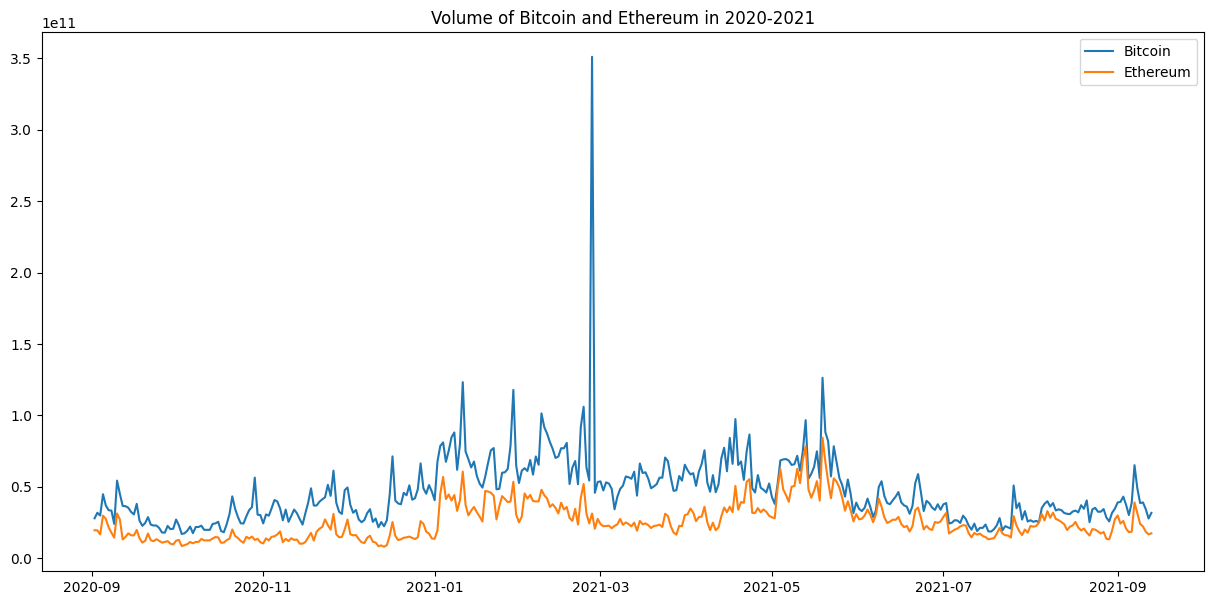

In [ ]:
fig = plt.figure(figsize=(15, 7))

plt.plot(period_btc_df['date'], period_btc_df['volume'])
plt.plot(period_eth_df['date'], period_eth_df['volume'])
plt.title('Volume of Bitcoin and Ethereum in 2020-2021')
plt.legend(['Bitcoin', 'Ethereum'])

plt.show()

Plotting last month open and close price price of last month open and close price of Bitcoin and Ethereum with comparison

In [ ]:
month_btc_df = btc_df[btc_df['date'] > '08-2021']
month_eth_df = eth_df[eth_df['date'] > '08-2021']

Text(0.5, 1.0, 'Ethereum')

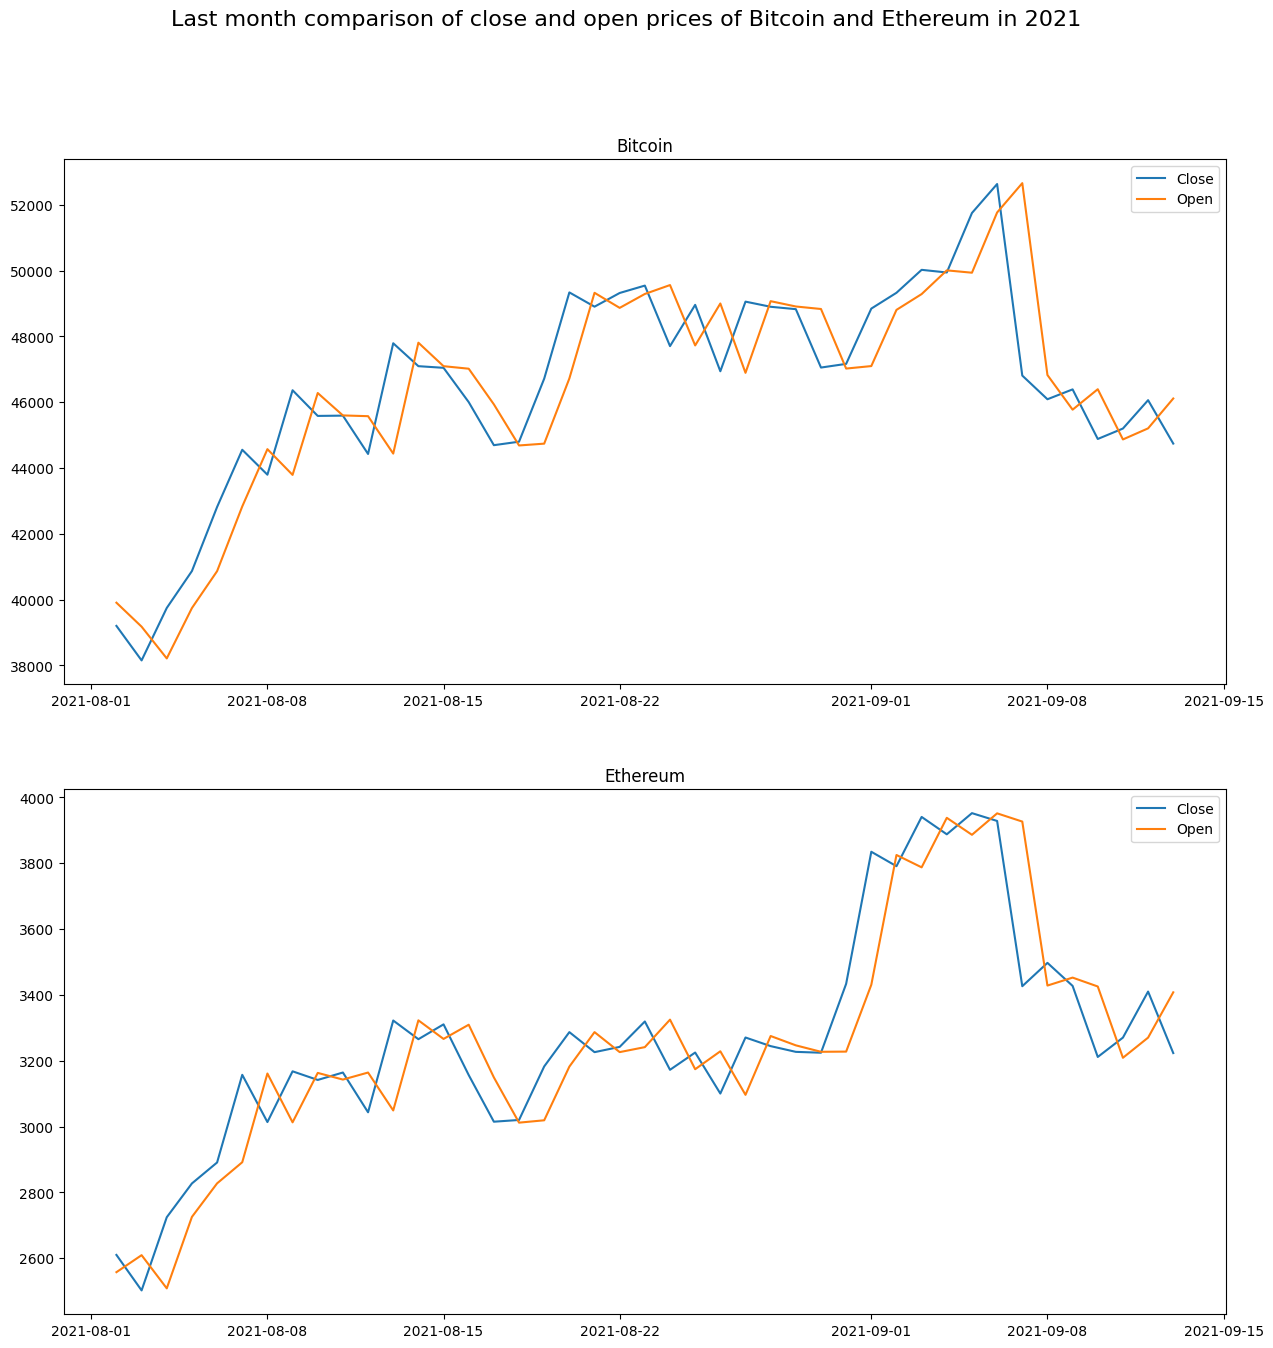

In [ ]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Last month comparison of close and open prices of Bitcoin and Ethereum in 2021"
, fontsize=16)
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(month_btc_df['date'], month_btc_df['close'])
plt.plot(month_btc_df['date'], month_btc_df['open'])
plt.legend(["Close", "Open"])
plt.title("Bitcoin")

plt.subplot(2, 1, 2)
plt.plot(month_eth_df['date'], month_eth_df['close'])
plt.plot(month_eth_df['date'], month_eth_df['open'])
plt.legend(["Close", "Open"])
plt.title("Ethereum")

### Moving Averages
The crypto prices are highly volatile and change quickly with time. To observe any trend or pattern we can take the help of a 50-day 200-day average.

Text(0.5, 1.0, 'Ethereum Close Price Moving Average')

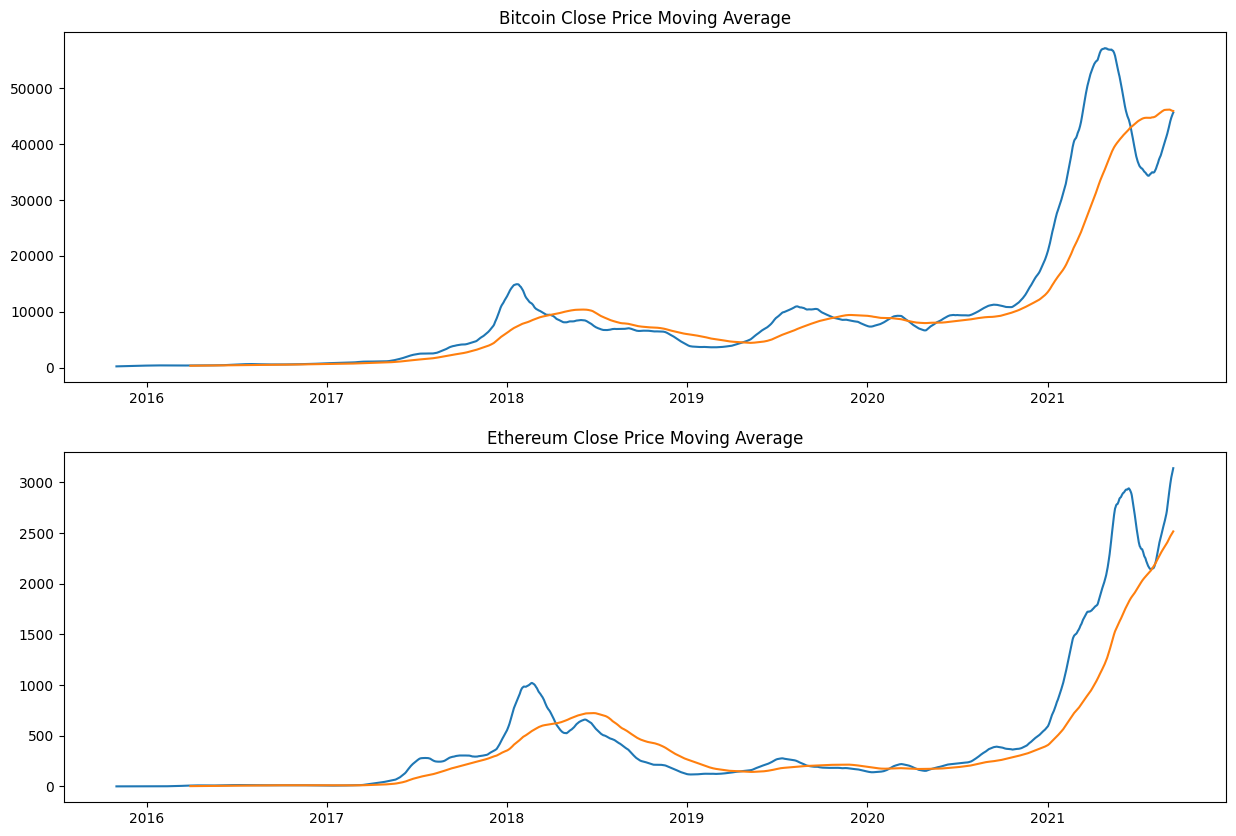

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(btc_df['date'], btc_df['close'].rolling(50).mean())
plt.plot(btc_df['date'], btc_df['close'].rolling(200).mean())
plt.title('Bitcoin Close Price Moving Average')

plt.subplot(2, 1, 2)
plt.plot(eth_df['date'], eth_df['close'].rolling(50).mean())
plt.plot(eth_df['date'], eth_df['close'].rolling(200).mean())
plt.title('Ethereum Close Price Moving Average')

Plotting histogram with mean indicator of BTC and ETH

Text(3100, 400, 'Ethereum Close Price')

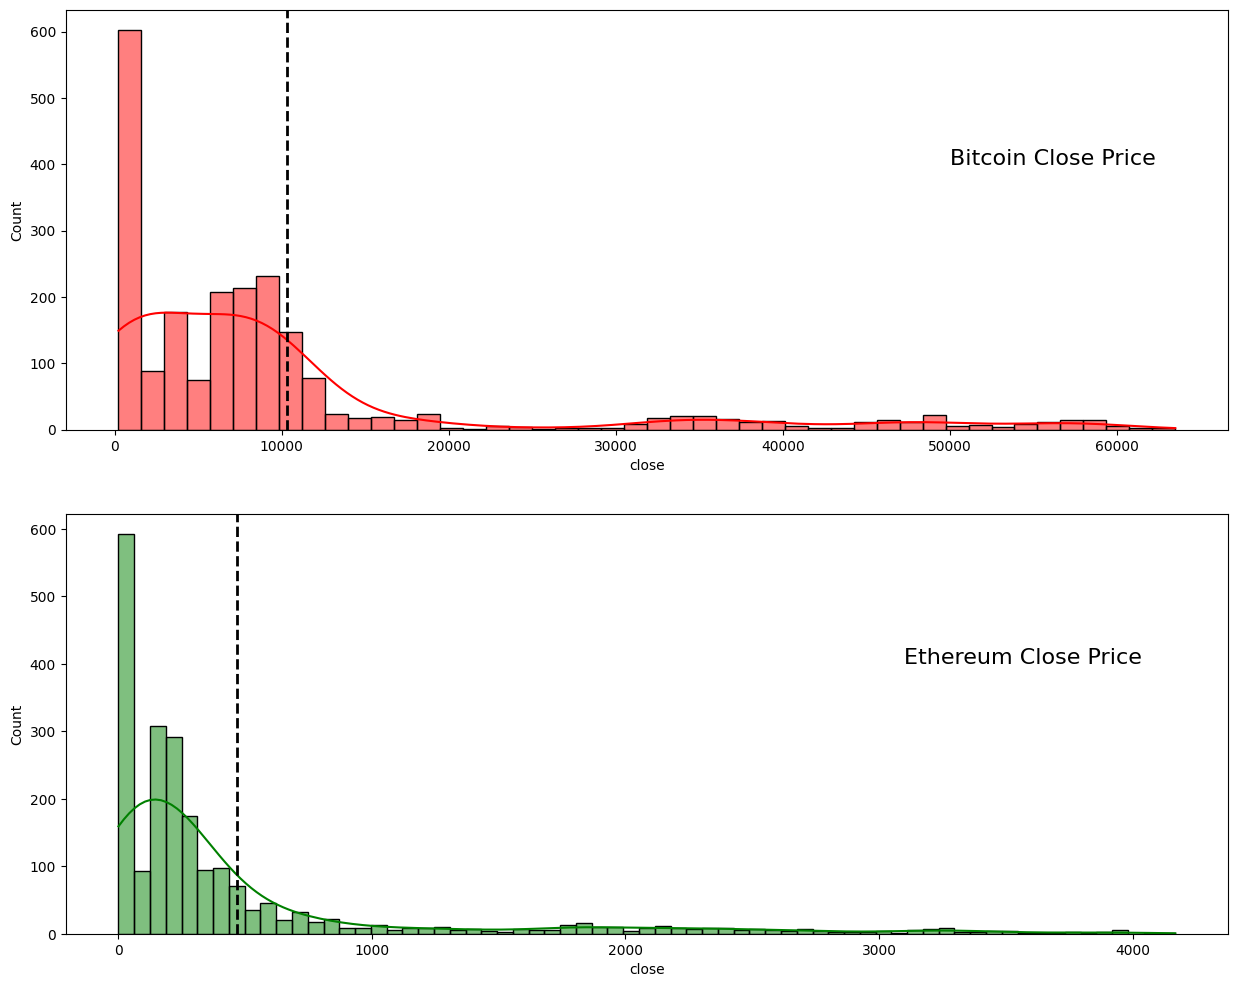

In [ ]:
fig = plt.figure(figsize=(15, 12))

fig.tight_layout()

plt.subplot(2, 1, 1)
sns.histplot(btc_df['close'], color='r', kde=True)
plt.axvline(btc_df['close'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.text(50000, 400, 'Bitcoin Close Price', fontsize=16)

plt.subplot(2, 1, 2)
sns.histplot(eth_df['close'], color='g', kde=True)
plt.axvline(eth_df['close'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.text(3100, 400, 'Ethereum Close Price', fontsize=16)

In [ ]:
btc_df.info()

In [ ]:
btc_df.hist(figsize=(18, 12))
plt.show()

## Bitcoin Close Price Prediction using XGBoost

In [ ]:
close_df = btc_df[['date', 'close']]
close_df.head()

In [22]:
close_df.shape

(2193, 2)

In [23]:
close_df = close_df[close_df['date'] > '2020-09-13']
close_stock = close_df.copy()
print("Total data for prediction: ", close_df.shape[0])

Total data for prediction:  365


In [24]:
del close_df['date']
scaler = MinMaxScaler(feature_range=(0, 1))
close_df = scaler.fit_transform(np.array(close_df).reshape(-1, 1))
print(close_df.shape)

(365, 1)


In [25]:
training_size=int(len(close_df) * 0.70)
test_size = len(close_df) - training_size
train_data, test_data = close_df[0:training_size, :], close_df[training_size:len(close_df), :1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


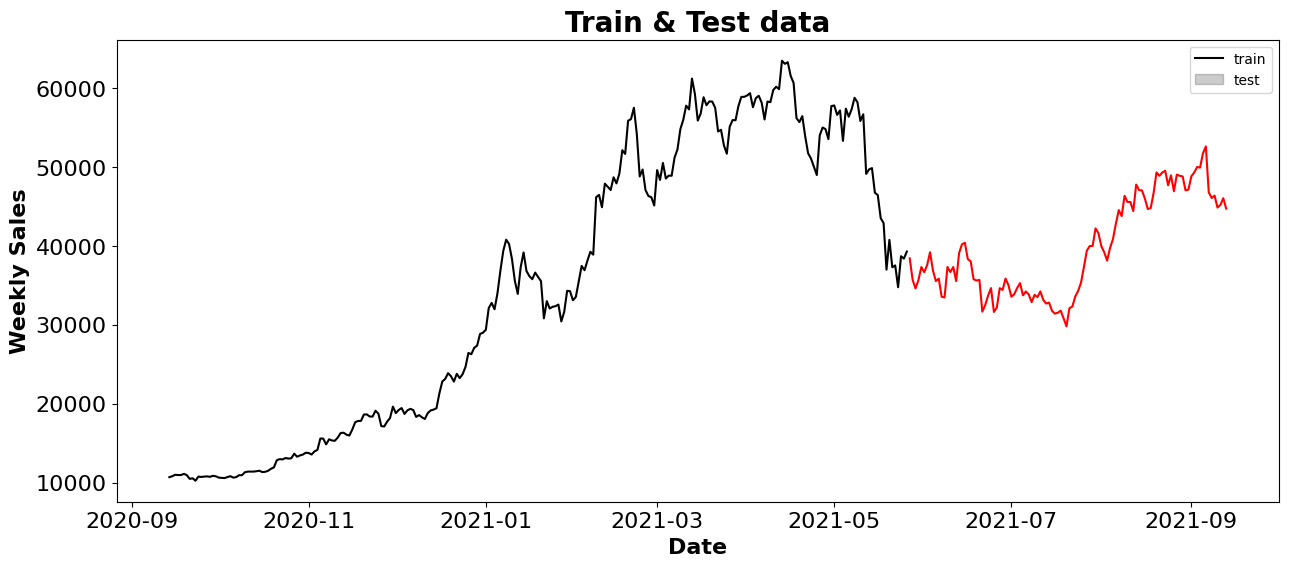

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=close_stock['date'][:255], y=close_stock['close'][:255], color='k')
sns.lineplot(x=close_stock['date'][255:], y=close_stock['close'][255:], color='r')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))


Preparre train data for time series analysis

In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [29]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model testing and evaluation

In [30]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error -  MAE: " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean Squared Error - RMSE: " +str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error -  MAE: 0.03075410308003782
Root Mean Squared Error - RMSE: 0.03971437751524892


In [31]:
train_predict = my_model.predict(X_train)
test_predict = my_model.predict(X_test)

train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (239, 1)
Test data prediction: (94, 1)


In [32]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [33]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [34]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = my_model.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [35]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [37]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(close_df[len(close_df)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [38]:
my_model=close_df.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()